In [1]:
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras import backend as K

2023-12-11 20:56:20.307936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Test if gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  2


2023-12-11 20:56:26.508452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:56:26.509073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:56:26.509426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

In [4]:
BTC_file_path = "./BTC-USD.csv"
ETH_file_path = "./ETH-USD.csv"
num_columns = len(np.genfromtxt(BTC_file_path, delimiter=',', max_rows=1))
load_string = lambda s: str(s)[2:-1]

value_converters = {i: lambda s: float(s or 0) for i in range(1,num_columns)}
value_converters[0] = load_string
name_converters = {i: load_string for i in range(num_columns)}

In [5]:
BTC_raw_data = np.genfromtxt(
    BTC_file_path, 
    delimiter=',', 
    skip_header=1,
    converters = value_converters,
    )

ETH_raw_data = np.genfromtxt(
    ETH_file_path, 
    delimiter=',', 
    skip_header=1,
    converters = value_converters,
    )

In [6]:
print(BTC_raw_data[0])
BTC_raw_data.shape


('2017-11-09', 7446.830078, 7446.830078, 7101.52002, 7143.580078, 7143.580078, 3.22624998e+09)


(2224,)

In [7]:
dates = [_data[0] for _data in BTC_raw_data]
BTC_open = [_data[1] for _data in BTC_raw_data]
BTC_high = [_data[2] for _data in BTC_raw_data]
BTC_low = [_data[3] for _data in BTC_raw_data]
BTC_close = [_data[4] for _data in BTC_raw_data]
BTC_volumn = [_data[6] for _data in BTC_raw_data]


ETH_open = [_data[1] for _data in ETH_raw_data]
ETH_high = [_data[2] for _data in ETH_raw_data]
ETH_low = [_data[3] for _data in ETH_raw_data]
ETH_close = [_data[4] for _data in ETH_raw_data]
ETH_volumn = [_data[6] for _data in ETH_raw_data]

data = [dates, BTC_open, BTC_high, BTC_low, BTC_close, BTC_volumn, ETH_open, ETH_high, ETH_low, ETH_close, ETH_volumn]


In [8]:
def get_day_of_year(date_str: str):
    date_object = datetime.strptime(date_str, "%Y-%m-%d")
    return (date_object - datetime(date_object.year, 1, 1)).days + 1

print("get_day_of_year".upper(), f": {dates[0]}")
print(get_day_of_year(dates[0]))

GET_DAY_OF_YEAR : 2017-11-09
313


In [9]:
def calculate_growth(base: int, target: int):
    return target/base

print("calculate_growth".upper())
print(calculate_growth(58,102))

CALCULATE_GROWTH
1.7586206896551724


In [10]:
"""
PROCESS DATA

X_data: proportion vs expected y_value
Y_data: proportion vs previous day y_value
"""
INPUT_SIZE = 60
PREDICT_PERIOD = 10
DATA_LENGTH = len(BTC_close)
X_data = []
Y_data = []


for i in range(DATA_LENGTH - INPUT_SIZE - PREDICT_PERIOD + 1):
    stack_data = []
    
    start_train_idx = i
    end_train_idx = start_train_idx + INPUT_SIZE - 1 # y_based_index
    predict_idx = end_train_idx + PREDICT_PERIOD # y_predict_index
    
    
    y_based_value = BTC_close[end_train_idx]
    doy = get_day_of_year(dates[end_train_idx])
    
    for crypto_data in data[1:]:
        interval_data = [doy] + [calculate_growth(x, y_based_value) for x in crypto_data[start_train_idx:start_train_idx+INPUT_SIZE]]
        stack_data.append(interval_data)

    X_data.append(stack_data)
    
    y_growth = calculate_growth(BTC_close[start_train_idx], BTC_close[predict_idx])
    
    Y_data.append(y_growth)


X_data = np.array(X_data)
Y_data = np.array(Y_data)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

In [11]:
print("Data dimension: ")
print("X dim:", len(X_data), len(X_data[0]), len(X_data[0][0]))
print("Y dim:", len(Y_data), "\n")
print("X begin: ", X_data[0][1][4])
print("X end: ", X_data[-1][1][4])
print("Y begin: ", Y_data[0])
print("Y end: ", Y_data[-1])


Data dimension: 
X dim: 2155 10 61
Y dim: 2155 

X begin:  2.4871661487833903
X end:  1.3693902905334292
Y begin:  1.5662454241196793
Y end:  1.5273856749673294


In [ ]:
# Default Model
K.clear_session()

EPOCH = 700
BATCH_SIZE = 64
VAL_SPLIT = 0.2

model = Sequential()
model.add(layers.Flatten(input_shape=(10, 61)))  
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear')) 

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    validation_split=VAL_SPLIT
)

# Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print(f"Mean Absoluted Error on Test Data: {test_loss}")

# Make predictions
predictions = model.predict(x_test)

Epoch 1/700


2023-12-11 20:56:41.752975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:56:41.753369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-11 20:56:41.753659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

22/22 [==============================] - 2s 7ms/step - loss: 4.5593 - val_loss: 1.1992
Epoch 2/700
22/22 [==============================] - 0s 2ms/step - loss: 0.6646 - val_loss: 0.3929
Epoch 3/700
22/22 [==============================] - 0s 2ms/step - loss: 0.3245 - val_loss: 0.3344
Epoch 4/700
22/22 [==============================] - 0s 2ms/step - loss: 0.2833 - val_loss: 0.2895
Epoch 5/700
22/22 [==============================] - 0s 2ms/step - loss: 0.2487 - val_loss: 0.2484
Epoch 6/700
22/22 [==============================] - 0s 2ms/step - loss: 0.2457 - val_loss: 0.2296
Epoch 7/700
22/22 [==============================] - 0s 2ms/step - loss: 0.2114 - val_loss: 0.2521
Epoch 8/700
22/22 [==============================] - 0s 2ms/step - loss: 0.1836 - val_loss: 0.1991
Epoch 9/700
22/22 [==============================] - 0s 2ms/step - loss: 0.1670 - val_loss: 0.1842
Epoch 10/700
22/22 [==============================] - 0s 2ms/step - loss: 0.1638 - val_loss: 0.1987
Epoch 11/700
22/22 [=

In [ ]:
model.summary()
print(f"Mean Absoluted Error on Test Data: {test_loss}")

In [ ]:
RANGE = 200
loss = history.history['loss'][RANGE:]
val_loss = history.history['val_loss'][RANGE:]

epochs_range = range(RANGE, EPOCH)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [123]:
y_predicted = np.array([predict[0] for predict in predictions])
y_test

cnt = 0
for i in range(len(y_predicted)):
    y_p = y_predicted[i]
    y_t = y_test[i]
    if y_p > 1 and y_t <= 1:
        cnt += 1
    if y_p <= 1 and y_t > 1:
        cnt += 1

print(cnt, "/", len(y_test))
print(cnt/len(y_test)*100)
pre_ft_acc = 100 - cnt/len(y_test)*100
print("Pre FT:", pre_ft_acc)

31 / 430
7.209302325581396
Pre FT: 92.79069767441861


In [124]:
model.save("./models/pre_ft.h5")

In [125]:
pre_ft_model = keras.models.load_model("./models/pre_ft.h5")

FT_EPOCH = 130
FT_BATCH_SIZE = 8
FT_VAL_SPLIT = 0.2
FT_LEARNING_RATE = 0.0001


pre_ft_model.compile(optimizer=Adam(learning_rate=FT_LEARNING_RATE), loss='mean_absolute_error')

fine_tuned_history = pre_ft_model.fit(
    x_train, 
    y_train, 
    epochs=FT_EPOCH, 
    batch_size=FT_BATCH_SIZE, 
    validation_split=FT_VAL_SPLIT
)

# Evaluate the model
fine_tuned_test_loss = pre_ft_model.evaluate(x_test, y_test)
print(f"Fine Tuned Mean Absoluted Error on Test Data: {fine_tuned_test_loss}")

# Make predictions
fine_tuned_predictions = pre_ft_model.predict(x_test)

Epoch 1/130
172/172 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0570
Epoch 2/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0543
Epoch 3/130
172/172 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0569
Epoch 4/130
172/172 [==============================] - 0s 1ms/step - loss: 0.0377 - val_loss: 0.0628
Epoch 5/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0537
Epoch 6/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0601
Epoch 7/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0532
Epoch 8/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0537
Epoch 9/130
172/172 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0546
Epoch 10/130
172/172 [==============================] - 0s 2ms/step - loss: 0.0376 - val_lo

In [126]:
pre_ft_model.summary()
print(f"Fine Tuned Mean Absoluted Error on Test Data: {fine_tuned_test_loss}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 610)               0         
                                                                 
 dense (Dense)               (None, 64)                39104     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 16)                2

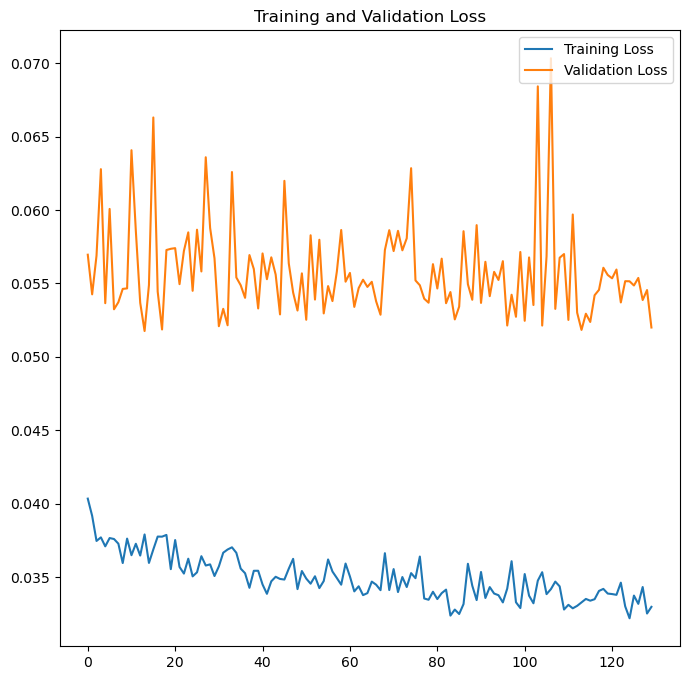

In [127]:
FT_RANGE = 0
loss = fine_tuned_history.history['loss'][FT_RANGE:]
val_loss = fine_tuned_history.history['val_loss'][FT_RANGE:]

epochs_range = range(FT_RANGE, FT_EPOCH)
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [128]:
y_predicted = np.array([predict[0] for predict in fine_tuned_predictions])

cnt = 0
for i in range(len(y_predicted)):
    y_p = y_predicted[i]
    y_t = y_test[i]
    if y_p > 1 and y_t <= 1:
        cnt += 1
    if y_p <= 1 and y_t > 1:
        cnt += 1

print(cnt, "/", len(y_test))
print(cnt/len(y_test)*100)
ft_acc = 100 - cnt/len(y_test)*100

16 / 430
3.7209302325581395


In [129]:
print("Loss:", test_loss, "->", fine_tuned_test_loss)
print("Acc:", pre_ft_acc, "->", ft_acc)

Loss: 0.06453939527273178 -> 0.05200603976845741
Acc: 92.79069767441861 -> 96.27906976744185


In [130]:
# pre_ft_model.save("./models/ft.h5")

In [45]:
# FT_RANGE = 0
# _y_test = y_test[FT_RANGE:]
# _y_predicted = fine_tuned_predictions[FT_RANGE:]

# data_range = range(FT_RANGE, len(_y_test))
# plt.figure(figsize=(20, 10))

# plt.plot(data_range, _y_test, label='Y TEST')
# plt.plot(data_range, _y_predicted, label='Y PREDICTED')
# plt.axhline(y=1, color='r', linestyle='-', label='y=1')
# plt.legend(loc='upper right')
# plt.title('Test and Predicted')
# plt.show()